In [1]:
%matplotlib inline
import sys
import scipy as sp
import os
import pickle
import h5py
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
import glob
import pandas as pd

In [42]:
basedir = '/cluster/work/grlab/projects/metagenome/data/gtex/queries'
align_dir = '/cluster/work/grlab/projects/metagenome/data/gtex/alignments_star_trans_exons/results/alignments'
file_metadata = '/cluster/work/grlab/projects/GTEx/metadata/SraRunTable_20180218.txt'
file_trans_exons = os.path.join(basedir, 'gencode.v30.trans_exons_all_hits.result_samples.txt')
plotdir = '/cluster/work/grlab/projects/metagenome/data/gtex/plots/trans_exons'
if not os.path.exists(plotdir):
    os.makedirs(plotdir)

In [3]:
### get metadata
metadata = pd.read_csv(file_metadata, delimiter='\t', index_col=16)

In [4]:
metadata.loc['SRR2135286']['AvgSpotLen']

101

In [13]:
### collect results
hits2samples = dict()
samples2hits = dict()
all_samples = []
all_trans = set()
excluded = set()
for line in open(file_trans_exons, 'r'):
    if line[0] == '[':
        continue
    sl = line.strip().split('\t')
    if len(sl) < 3:
        for s in sl[1].split(';'):
            excluded.add(s)
        continue
    all_trans.add(sl[1].split(';')[0])
    ### ignore hits that occur in more than 1K samples
    if len(sl) > 1000:
        continue
    for s in sl[2:]:
        cs = s.split(':')[0][1:-1]
        all_samples.append(cs)
        try:
            samples2hits[cs].append(sl[1])
        except KeyError:
            samples2hits[cs] = [sl[1]]
        try: 
            hits2samples[sl[1]].append(cs)
        except KeyError:
            hits2samples[sl[1]] = [cs]

In [30]:
### collect support counts
read_counts = []
for sample in samples2hits:
    if not os.path.exists(os.path.join(align_dir, '%s.hits' % sample)):
        continue
    for t in samples2hits[sample]:
        flist = glob.glob(os.path.join(align_dir, '%s.hits' % sample, '%s.all.%s.*.cnt' % (sample, t)))
        if len(flist) == 0:
            continue
        assert len(flist) == 2
        curr_count = 0
        for fname in flist:
            for line in open(fname, 'r'):
                curr_count += int(line.strip())
        read_counts.append(curr_count)

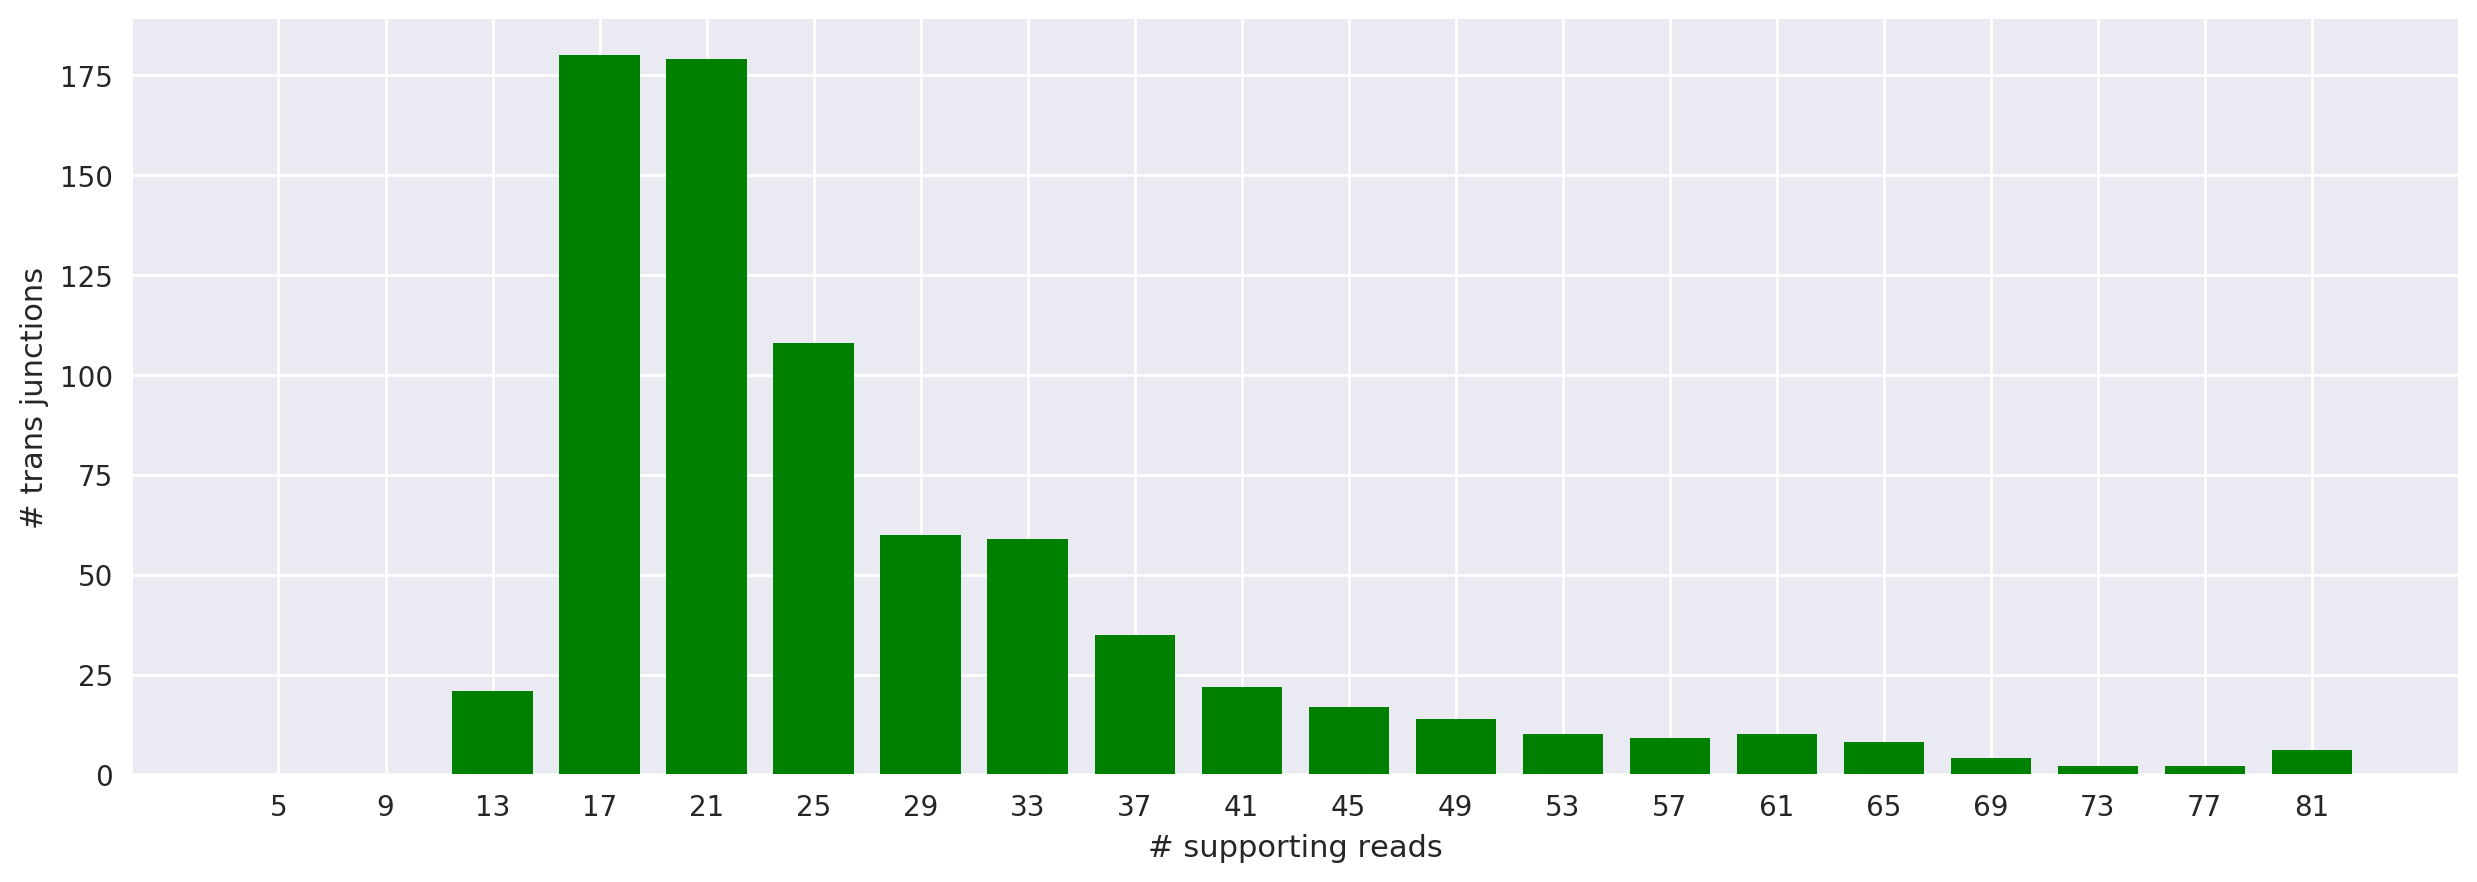

In [52]:
### plot read support distribution
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(15,5), dpi=200)
    ax = fig.add_subplot(111)
    h = sp.histogram(read_counts, range=(1, 81), bins=20)
    ax.bar(h[1][1:], h[0], width=3, color='g')
    ax.set_xticks(h[1][1:])
    ax.set_ylabel('# trans junctions')
    ax.set_xlabel('# supporting reads')
    plt.savefig(os.path.join(plotdir, 'trans_junction_read_support.png'), format='png', bbox_inches='tight')
    plt.savefig(os.path.join(plotdir, 'trans_junction_read_support.pdf'), format='pdf', bbox_inches='tight')

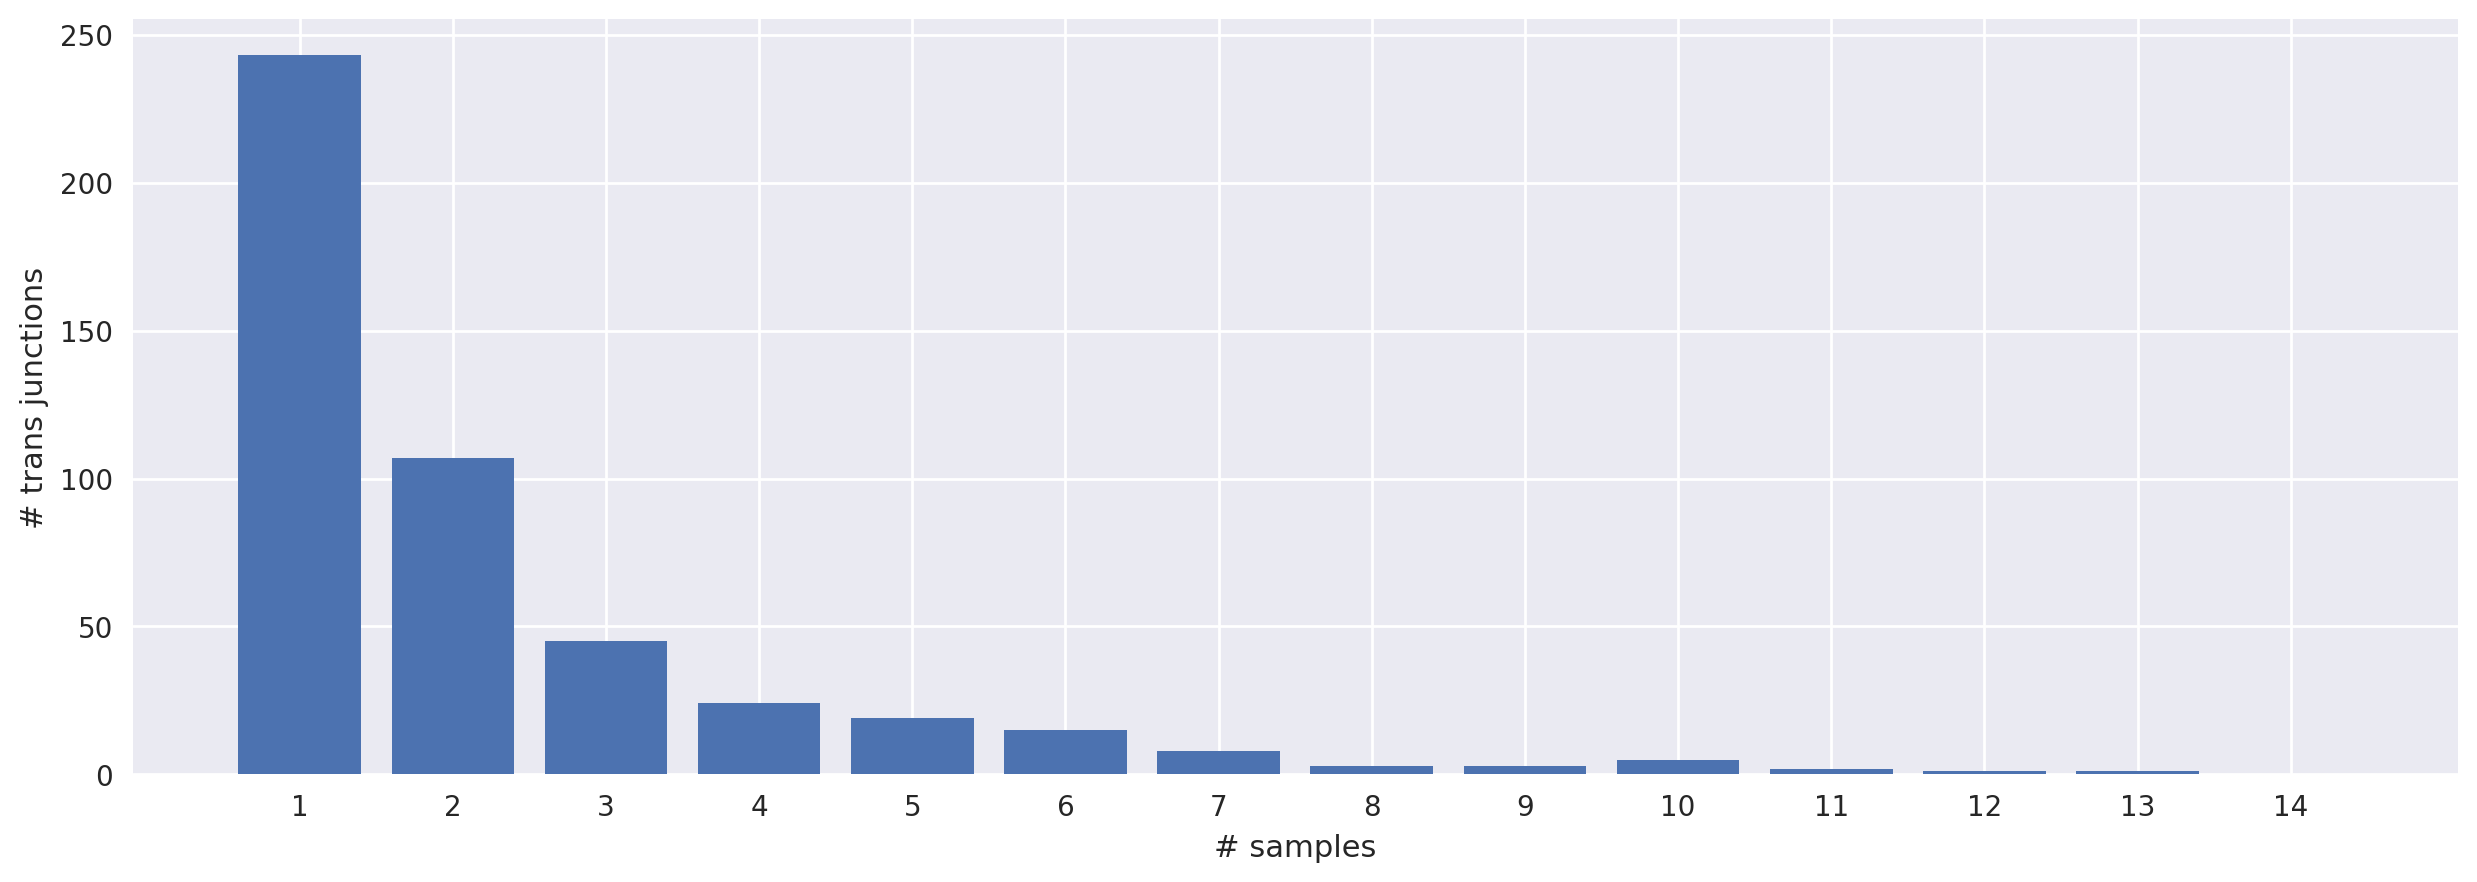

In [48]:
### plot distribution of samples across hits
count = [len(hits2samples[_]) for _ in hits2samples]
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(15,5), dpi=200)
    ax = fig.add_subplot(111)
    h = sp.histogram(count, range=(1,15), bins=14)
    ax.bar(sp.arange(1, 15), h[0])
    ax.set_xticks(sp.arange(1, 15))
    ax.set_ylabel('# trans junctions')
    ax.set_xlabel('# samples')
    plt.savefig(os.path.join(plotdir, 'samples_per_trans_junction.png'), format='png', bbox_inches='tight')
    plt.savefig(os.path.join(plotdir, 'samples_per_trans_junction.pdf'), format='pdf', bbox_inches='tight')

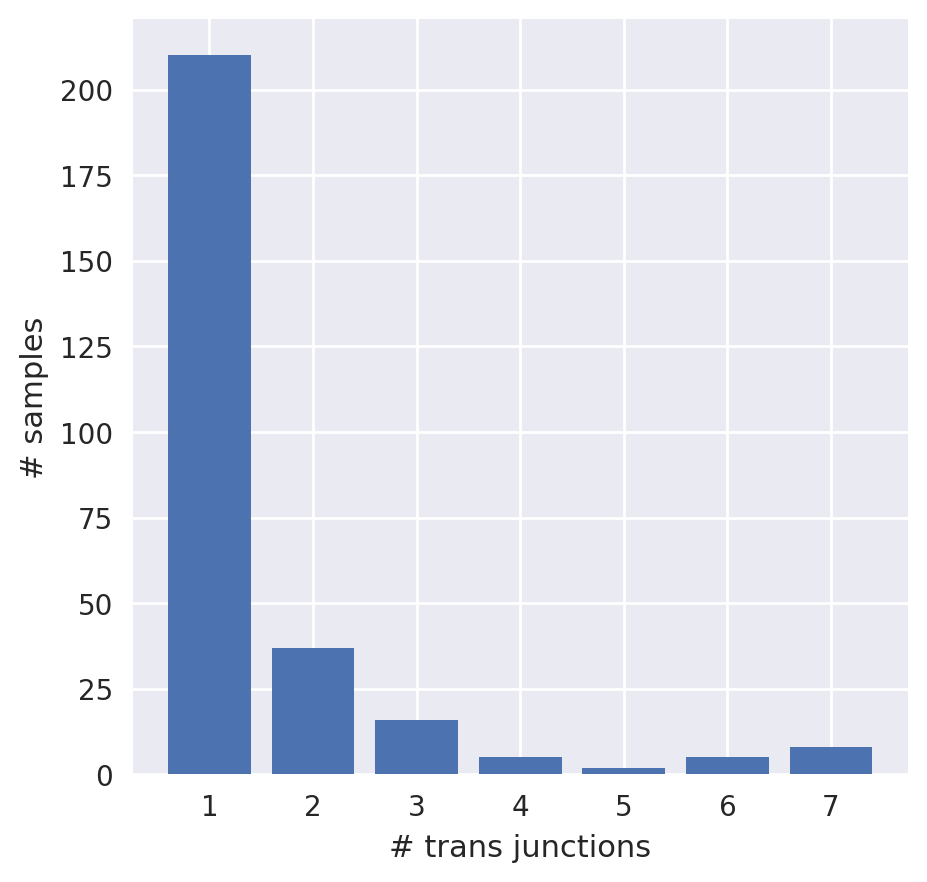

In [47]:
### plot distribution of samples across hits
count = [len(samples2hits[_]) for _ in samples2hits]
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(5,5), dpi=200)
    ax = fig.add_subplot(111)
    h = sp.histogram(count, range=(1,8), bins=7)
    ax.bar(sp.arange(1, 8), h[0])
    ax.set_xticks(sp.arange(1, 8))
    ax.set_ylabel('# samples')
    ax.set_xlabel('# trans junctions')
    plt.savefig(os.path.join(plotdir, 'trans_junction_per_sample.png'), format='png', bbox_inches='tight')
    plt.savefig(os.path.join(plotdir, 'trans_junction_per_sample.pdf'), format='pdf', bbox_inches='tight')

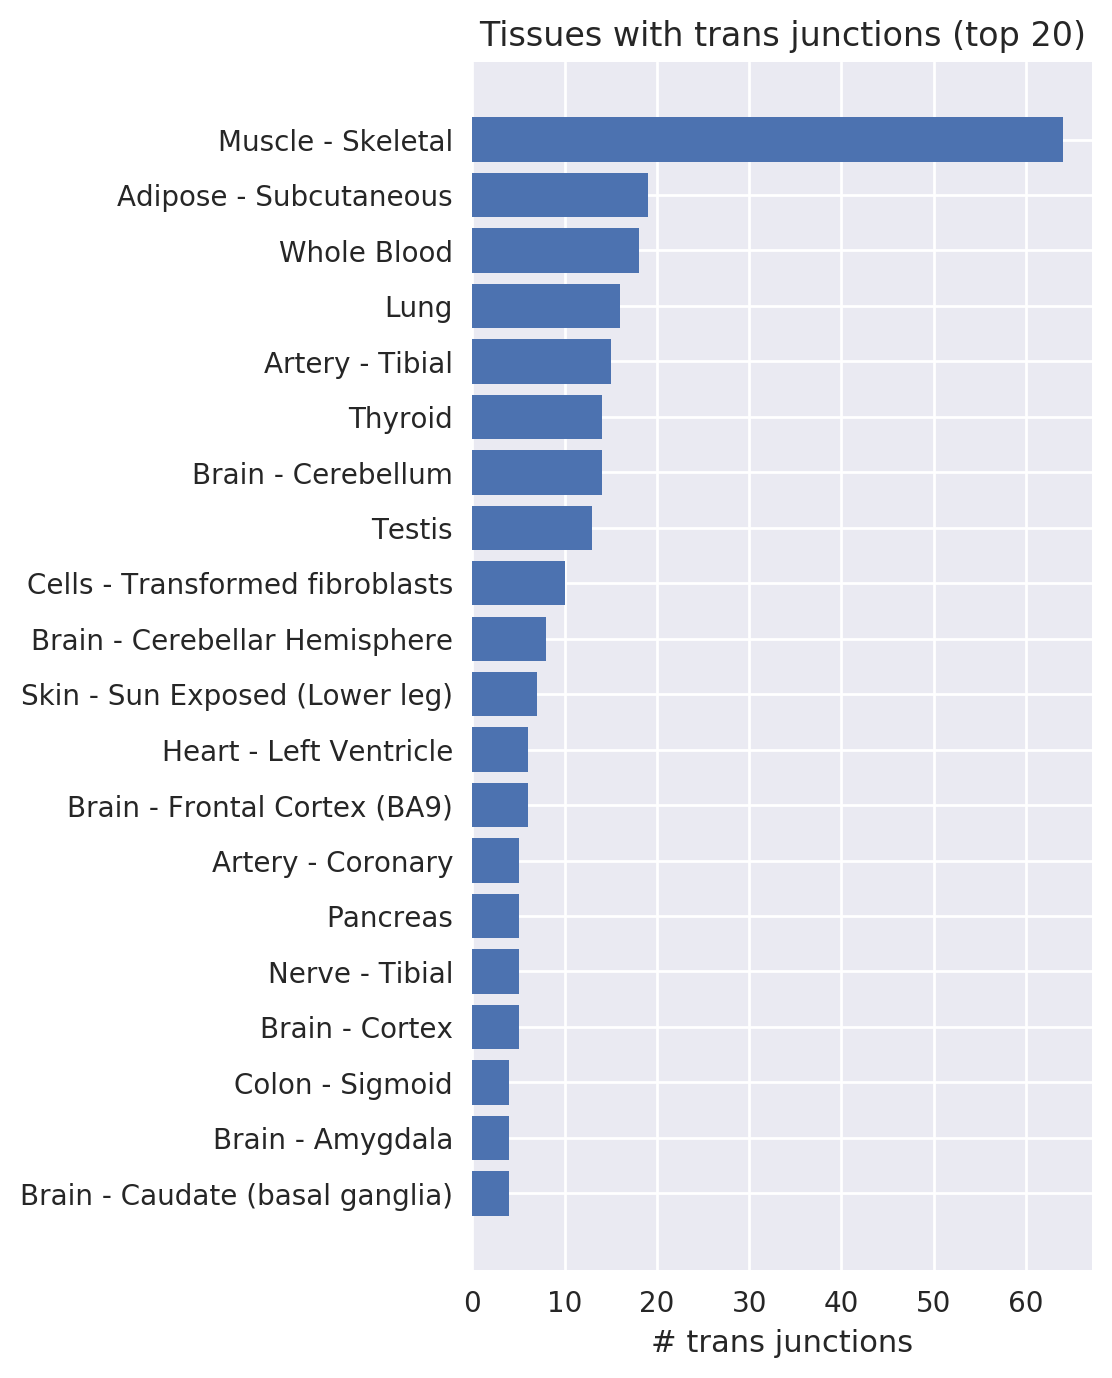

In [51]:
### associate hits with tissues
tissues = [metadata.loc[_]['body_site'] for _ in sp.unique(all_samples)]
tissues_u, tissues_c = sp.unique(tissues, return_counts=True)
s_idx = sp.argsort(tissues_c)[-20:]
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(4,8), dpi=200)
    ax = fig.add_subplot(111)
    ax.barh(sp.arange(s_idx.shape[0]), tissues_c[s_idx])
    ax.set_yticks(sp.arange(s_idx.shape[0]))
    ax.set_yticklabels(tissues_u[s_idx])
    #ax.set_ylabel('# samples')
    ax.set_xlabel('# trans junctions')
    ax.set_title('Tissues with trans junctions (top 20)')
    plt.savefig(os.path.join(plotdir, 'trans_junction_top_tissues.png'), format='png', bbox_inches='tight')
    plt.savefig(os.path.join(plotdir, 'trans_junction_top_tissues.pdf'), format='pdf', bbox_inches='tight')